In [1]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM,GRU,Conv1D,Conv2D,Flatten,Dropout,MaxPooling1D,GlobalAveragePooling1D
import tensorflow.keras.optimizers  as opt
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
## load the data files
with open('time_series_1.pickle','rb') as handle:
    time_series_1 = pickle.load(handle)
with open('time_series_2.pickle','rb') as handle:
    time_series_2 = pickle.load(handle)   
with open('y.pickle','rb') as handle:
    y = pickle.load(handle)

## Task 1

In this project, prediction approach of  sequence-to-vector is most sensible to predict the operating mode of a turbine.

In [3]:
x = np.dstack([time_series_1,time_series_2])

## dataset split,70% for training,15% for validation,15% for testing
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
x_test,x_valid,y_test,y_valid = train_test_split(x_test,y_test,test_size=0.5,random_state=0)

## x_final and y_final will be applied for final training after best model was selected.
x_final = np.vstack((x_train,x_valid))
y_final = np.hstack((y_train,y_valid))
x_train.shape,x_test.shape,x_valid.shape,x_final.shape

((2800, 5000, 2), (600, 5000, 2), (600, 5000, 2), (3400, 5000, 2))

## Task 2

In [4]:
## create dataset iterator that produces batches of data
def loader(x,y,BATCH_SIZE = 32,SHUFFLE_BUFFER_SIZE = 100): 
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset
    
train_loader = loader(x_train,y_train)
test_loader = loader(x_test,y_test)
valid_loader = loader(x_valid,y_valid)
final_loader =  loader(x_final,y_final)

## Task 3

In [5]:
## set random seed in all model training process for reproducible
def set_seed(seed):
    np.random.seed(0)
    tf.random.set_seed(0)

## model training function
def train(model,seed=0):
    set_seed(seed)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=opt.Adam(),metrics = ['accuracy'])
    check_model = tf.keras.callbacks.ModelCheckpoint(f"{model.name}_best_model.h5", save_best_only=True)
    log = model.fit(train_loader,epochs=20,validation_data=valid_loader)
    return log

## loss curve plot
def loss_plot(log):
    plt.plot(log.history['loss'],label = "training loss")
    plt.plot(log.history['val_loss'], label = "validation loss")
    plt.xlabel('Number of epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

#### lstm model

In [118]:
lstm = Sequential([
    LSTM(100,return_sequences=True,input_shape=[None,2]),
    LSTM(100),
    Dense(4)
],name='lstm')
lstm.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 100)         41200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_68 (Dense)             (None, 4)                 404       
Total params: 122,004
Trainable params: 122,004
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
88/88 [==============================] - 43s 451ms/step - loss: 1.3823 - accuracy: 0.2875 - val_loss: 1.3691 - val_accuracy: 0.2717
Epoch 2/20
88/88 [==============================] - 39s 449ms/step - loss: 1.3360 - accuracy: 0.3489 - val_loss: 1.3318 - val_accuracy: 0.3083
Epoch 3/20
88/88 [==============================] - 39s 445ms/step - loss: 1.2909 - accuracy: 0.4021 - val_loss: 1.2885 - val_accuracy: 0.4033
Epoch 4/20
88/88 [==============================] - 40s 456ms/step - loss: 1.2263 - accuracy: 0.4454 - val_loss: 1.2187 - val_accuracy: 0.4367
Epoch 5/20
88/88 [==============================] - 38s 436ms/step - loss: 1.2189 - accuracy: 0.4386 - val_loss: 1.2384 - val_accuracy: 0.4367
Epoch 6/20
88/88 [==============================] - 39s 438ms/step - loss: 1.1223 - accuracy: 0.4921 - val_loss: 1.1065 - val_accuracy: 0.4900
Epoch 7/20
88/88 [==============================] - 39s 443ms/step - loss: 1.0197 - accuracy: 0.5504 - val_loss: 1.0229 - val_accuracy: 0.5267

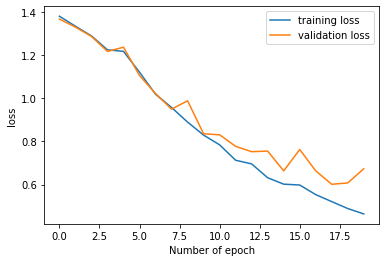

In [119]:
lstm_log = train(lstm)
loss_plot(lstm_log)

#### gru model

In [113]:
gru = Sequential([
    GRU(100,return_sequences=True,input_shape=[None,2]),
    GRU(100),
    Dense(4)
],name='gru')
gru.summary()

Model: "gru"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 100)         31200     
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_66 (Dense)             (None, 4)                 404       
Total params: 92,204
Trainable params: 92,204
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
88/88 [==============================] - 41s 437ms/step - loss: 1.3881 - accuracy: 0.2986 - val_loss: 1.3535 - val_accuracy: 0.3383
Epoch 2/20
88/88 [==============================] - 38s 436ms/step - loss: 1.2984 - accuracy: 0.3796 - val_loss: 1.2589 - val_accuracy: 0.4217
Epoch 3/20
88/88 [==============================] - 39s 438ms/step - loss: 1.0910 - accuracy: 0.5218 - val_loss: 1.0863 - val_accuracy: 0.5150
Epoch 4/20
88/88 [==============================] - 37s 417ms/step - loss: 0.8848 - accuracy: 0.6282 - val_loss: 0.9328 - val_accuracy: 0.6183
Epoch 5/20
88/88 [==============================] - 38s 437ms/step - loss: 0.7303 - accuracy: 0.7000 - val_loss: 0.6362 - val_accuracy: 0.7167
Epoch 6/20
88/88 [==============================] - 38s 435ms/step - loss: 0.6611 - accuracy: 0.7179 - val_loss: 0.6291 - val_accuracy: 0.7167
Epoch 7/20
88/88 [==============================] - 38s 433ms/step - loss: 0.5379 - accuracy: 0.7807 - val_loss: 0.6563 - val_accuracy: 0.7300

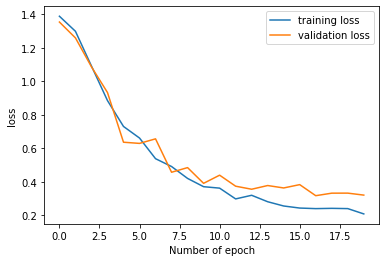

In [114]:
gru_log = train(gru)
loss_plot(gru_log)

Compare the training logs between lstm and gru model, we can find gru is better than lstm in the same experimental setting. Therefore, I wil use GRU module to construct new model for improving performance.

#### different layers and element combination

In [115]:
conv_gru = Sequential([
    Conv1D(8, 24, strides=2, padding='valid',activation="relu",input_shape=[None,2]),
    MaxPooling1D(2),
    Conv1D(16, 12, activation="relu"),
    MaxPooling1D(2),
    Conv1D(32, 6, activation="relu"),
    GRU(100),
    Dense(4)
],name='conv_gru')
conv_gru.summary()

Model: "conv_gru"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 8)           392       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1552      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          3104      
_________________________________________________________________
gru_4 (GRU)                  (None, 100)               40200     
_________________________________________________________________
dense_67 (Dense)             (None, 4)                 404

Epoch 1/20
88/88 [==============================] - 6s 46ms/step - loss: 1.0944 - accuracy: 0.5311 - val_loss: 0.8461 - val_accuracy: 0.6250
Epoch 2/20
88/88 [==============================] - 3s 39ms/step - loss: 0.7415 - accuracy: 0.6904 - val_loss: 0.5778 - val_accuracy: 0.7750
Epoch 3/20
88/88 [==============================] - 3s 40ms/step - loss: 0.5385 - accuracy: 0.7818 - val_loss: 0.5268 - val_accuracy: 0.7867
Epoch 4/20
88/88 [==============================] - 4s 40ms/step - loss: 0.4240 - accuracy: 0.8475 - val_loss: 0.3738 - val_accuracy: 0.8733
Epoch 5/20
88/88 [==============================] - 4s 41ms/step - loss: 0.3786 - accuracy: 0.8454 - val_loss: 0.3622 - val_accuracy: 0.8600
Epoch 6/20
88/88 [==============================] - 4s 40ms/step - loss: 0.3531 - accuracy: 0.8550 - val_loss: 0.3744 - val_accuracy: 0.8550
Epoch 7/20
88/88 [==============================] - 3s 39ms/step - loss: 0.3007 - accuracy: 0.8796 - val_loss: 0.3922 - val_accuracy: 0.8600
Epoch 8/20
88

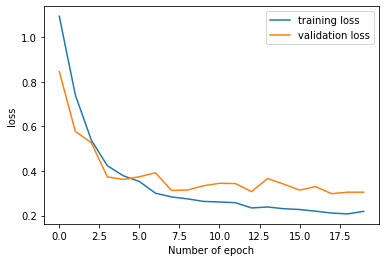

In [116]:
conv_gru_log = train(conv_gru)
loss_plot(conv_gru_log)

In [120]:
res = [[],[]]
for obj in [lstm_log,gru_log,conv_gru_log]:
    idx = np.argmax(obj.history['val_accuracy'])
    res[0].append(obj.history['val_accuracy'][idx])
    res[1].append(obj.history['val_loss'][idx])
res_df = pd.DataFrame(data=np.array(res).T,columns=['val_accuracy','val_loss'],index=['lstm','gru','conv_gru'])
res_df

,val_accuracy,val_loss
lstm,0.753333,0.601033
gru,0.863333,0.320458
conv_gru,0.883333,0.307902


From the comparing the best performance of each model, conv_gru achieve is best. Furthermore, from the training log, we can see that conv_gru's training speed is 10 times faster than lstm and gru. The number of total parameters of conv_gru almost be half of that in lstm and gru.

## Task 4

## Task 5

## Task 6

In [6]:
def convert(data):
    dim0,dim1,_ = data.shape
    convert_data = np.zeros((dim0,100,100))
    for i in range(dim0):
        mat1 = data[i,:,0]
        mat2 = data[i,:,1]
        convert_data[i] = np.hstack((mat1.reshape(100,50),mat2.reshape(100,50)))
    convert_data = convert_data.reshape(dim0,100,100,1)   
    return convert_data.astype('float32')

convert_x_train = convert(x_train)
convert_x_test = convert(x_test)
convert_x_valid = convert(x_valid)
convert_x_final = convert(x_final)

convert_train_loader = loader(convert_x_train,y_train)
convert_test_loader = loader(convert_x_test,y_test)
convert_valid_loader = loader(convert_x_valid,y_valid)
convert_final_loader =  loader(convert_x_final,y_final)

print(f'After converting, the train dataset shape:{convert_x_train.shape}')
print(f'After converting, the test dataset shape:{convert_x_test.shape}')
print(f'After converting, the validation dataset shape:{convert_x_valid.shape}')
print(f'After converting, the final train dataset shape:{convert_x_final.shape}')

After converting, the train dataset shape:(2800, 100, 100, 1)
After converting, the test dataset shape:(600, 100, 100, 1)
After converting, the validation dataset shape:(600, 100, 100, 1)
After converting, the final train dataset shape:(3400, 100, 100, 1)


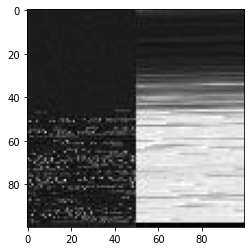

In [7]:
## take an example from the training dataset for visualization
ex = np.squeeze(convert_x_train[0],axis=-1)
plt.imshow(ex,cmap='gray')
plt.show()

## Task 7

In [40]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,GlobalAveragePooling2D,BatchNormalization

In [8]:
def train_convert_data(model,seed=0):
    set_seed(seed)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=opt.Adam(),metrics = ['accuracy'])
    check_model = tf.keras.callbacks.ModelCheckpoint(f"{model.name}_best_model.h5", save_best_only=True)
    log = model.fit(convert_train_loader,epochs=20,validation_data=convert_valid_loader)
    return log

In [104]:
cnn3_32 = Sequential([
    Conv2D(32, 3,padding='same',input_shape=(100,100,1)),
    Conv2D(32, 3,padding='same'),
    Dropout(0.2),
    Conv2D(16, 3,padding='same',activation='relu'),
    MaxPooling2D(3),
    Flatten(),
    Dense(4)
],name='cnn3_32')
cnn3_32.summary()

Model: "cnn3_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 100, 100, 32)      9248      
_________________________________________________________________
dropout_32 (Dropout)         (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 100, 100, 16)      4624      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 33, 33, 16)        0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 17424)             0         
_________________________________________________________________
dense_63 (Dense)             (None, 4)                 6970

Epoch 1/20
88/88 [==============================] - 1s 12ms/step - loss: 9.8072 - accuracy: 0.2707 - val_loss: 1.3857 - val_accuracy: 0.2617
Epoch 2/20
88/88 [==============================] - 1s 10ms/step - loss: 1.3830 - accuracy: 0.2825 - val_loss: 1.3786 - val_accuracy: 0.3150
Epoch 3/20
88/88 [==============================] - 1s 10ms/step - loss: 1.3278 - accuracy: 0.3454 - val_loss: 1.1601 - val_accuracy: 0.6217
Epoch 4/20
88/88 [==============================] - 1s 10ms/step - loss: 1.0799 - accuracy: 0.5243 - val_loss: 0.7814 - val_accuracy: 0.7333
Epoch 5/20
88/88 [==============================] - 1s 10ms/step - loss: 0.6866 - accuracy: 0.7382 - val_loss: 0.3491 - val_accuracy: 0.8800
Epoch 6/20
88/88 [==============================] - 1s 10ms/step - loss: 0.3634 - accuracy: 0.8646 - val_loss: 0.3132 - val_accuracy: 0.8733
Epoch 7/20
88/88 [==============================] - 1s 10ms/step - loss: 0.3024 - accuracy: 0.8736 - val_loss: 0.3075 - val_accuracy: 0.8817
Epoch 8/20
88

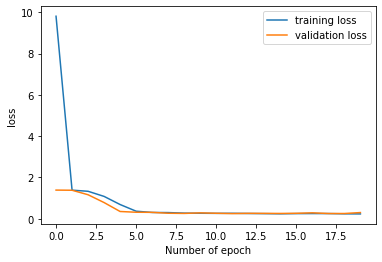

In [105]:
cnn3_32_log = train_convert_data(cnn3_32)
loss_plot(cnn3_32_log)

In [106]:
print(f'Final validation result is:')
cnn3_32.evaluate(convert_valid_loader)

Final validation result is:
19/19 [==============================] - 0s 5ms/step - loss: 0.2975 - accuracy: 0.8767


[0.2975205183029175, 0.8766666650772095]

## Task 8

In [82]:
#### Adding 2 convolution layers and 1 fc layer
cnn5_256 = Sequential([
    Conv2D(256,3,2,padding='same',input_shape=(100,100,1),activation='relu'),
    Conv2D(128,3,1,padding='same',activation='relu'),
    Dropout(0.2),
    Conv2D(64,3,padding='same',activation='relu'),
    Conv2D(32,3,padding='same',activation='relu'),
    Conv2D(16,3,padding='same',activation='relu'),
    MaxPooling2D(3),
    Flatten(),
    Dense(32),
    Dense(4)
],name='cnn5_256')
cnn5_256.summary()

Model: "cnn5_256"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 50, 50, 256)       2560      
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 50, 50, 128)       295040    
_________________________________________________________________
dropout_31 (Dropout)         (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 50, 50, 64)        73792     
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 50, 50, 32)        18464     
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 50, 50, 16)        4624      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 16)        0  

Epoch 1/20
88/88 [==============================] - 2s 19ms/step - loss: 2.8082 - accuracy: 0.2729 - val_loss: 1.3235 - val_accuracy: 0.4267
Epoch 2/20
88/88 [==============================] - 1s 17ms/step - loss: 0.7878 - accuracy: 0.6957 - val_loss: 0.4139 - val_accuracy: 0.8883
Epoch 3/20
88/88 [==============================] - 1s 17ms/step - loss: 0.3247 - accuracy: 0.8836 - val_loss: 0.2546 - val_accuracy: 0.8883
Epoch 4/20
88/88 [==============================] - 1s 17ms/step - loss: 0.2709 - accuracy: 0.8904 - val_loss: 0.2683 - val_accuracy: 0.8717
Epoch 5/20
88/88 [==============================] - 1s 17ms/step - loss: 0.2624 - accuracy: 0.8889 - val_loss: 0.2489 - val_accuracy: 0.8817
Epoch 6/20
88/88 [==============================] - 2s 17ms/step - loss: 0.2534 - accuracy: 0.8907 - val_loss: 0.2623 - val_accuracy: 0.8967
Epoch 7/20
88/88 [==============================] - 2s 17ms/step - loss: 0.2493 - accuracy: 0.8979 - val_loss: 0.2612 - val_accuracy: 0.8617
Epoch 8/20
88

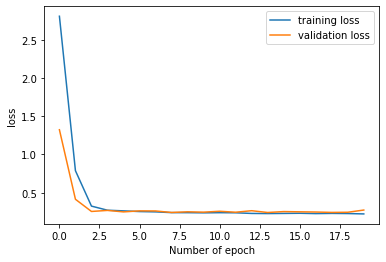

In [83]:
cnn5_256_log = train_convert_data(cnn5_256)
loss_plot(cnn5_256_log)

#### pretrained model

In [99]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16

In [108]:
vgg = VGG16(weights='imagenet', input_shape = (100,100,3),include_top=False)
for layer in vgg.layers:
    layer.trainable= False

vgg_model = Sequential([
    Conv2D(3,1,1,input_shape=(100,100,1)),
    vgg,
    Flatten(),
    Dense(4)
],name='vgg_model')
vgg_model.summary()

Model: "vgg_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_119 (Conv2D)          (None, 100, 100, 3)       6         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_29 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 4)                 18436     
Total params: 14,733,130
Trainable params: 18,442
Non-trainable params: 14,714,688
_________________________________________________________________


In [109]:
vgg_model_log = train_convert_data(vgg_model)

Epoch 1/20
88/88 [==============================] - 3s 27ms/step - loss: 2.3548 - accuracy: 0.3964 - val_loss: 0.9629 - val_accuracy: 0.6467
Epoch 2/20
88/88 [==============================] - 2s 24ms/step - loss: 1.0107 - accuracy: 0.5721 - val_loss: 0.8707 - val_accuracy: 0.7217
Epoch 3/20
88/88 [==============================] - 2s 25ms/step - loss: 0.7670 - accuracy: 0.7111 - val_loss: 0.7305 - val_accuracy: 0.7500
Epoch 4/20
88/88 [==============================] - 2s 25ms/step - loss: 0.5941 - accuracy: 0.7886 - val_loss: 0.5845 - val_accuracy: 0.7267
Epoch 5/20
88/88 [==============================] - 2s 25ms/step - loss: 0.5039 - accuracy: 0.8289 - val_loss: 0.4806 - val_accuracy: 0.8433
Epoch 6/20
88/88 [==============================] - 2s 25ms/step - loss: 0.4194 - accuracy: 0.8475 - val_loss: 0.4607 - val_accuracy: 0.7883
Epoch 7/20
88/88 [==============================] - 2s 24ms/step - loss: 0.4541 - accuracy: 0.8386 - val_loss: 0.6084 - val_accuracy: 0.7600
Epoch 8/20
88

In [ ]:
print(f'')

## Task 9

In [123]:
model_log = [lstm_log,gru_log,conv_gru_log,cnn3_32_log,cnn5_256_log,vgg_model_log]
res = [[],[]]
for obj in model_log:
    idx = np.argmax(obj.history['val_accuracy'])
    res[0].append(obj.history['val_accuracy'][idx])
    res[1].append(obj.history['val_loss'][idx])
res_df = pd.DataFrame(data=np.array(res).T,columns=['val_accuracy','val_loss'],index=['lstm','gru','conv_gru','cnn3_32','cnn5_256','vgg_model'])
res_df

,val_accuracy,val_loss
lstm,0.753333,0.601033
gru,0.863333,0.320458
conv_gru,0.883333,0.307902
cnn3_32,0.893333,0.251495
cnn5_256,0.898333,0.244718
vgg_model,0.893333,0.334490


From the results, we can see that cnn3_32 and cnn5_256 have the same validation accuracy, but loss of cnn5_256 is smaller than that of cnn3_32. Therefore, I choose the cnn5_256 as best model

In [131]:
best_model = cnn5_256
best_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=opt.Adam(),metrics = ['accuracy'])
check_model = tf.keras.callbacks.ModelCheckpoint(f"best_model.h5", save_best_only=True)
best_model_log = model.fit(convert_final_loader,epochs=20,validation_data=convert_test_loader)
print(f"Best testing accuracy is {max(best_model_log.history['val_accuracy'])}")

Epoch 1/20
107/107 [==============================] - 1s 11ms/step - loss: 0.2225 - accuracy: 0.9026 - val_loss: 0.2498 - val_accuracy: 0.8867
Epoch 2/20
107/107 [==============================] - 1s 11ms/step - loss: 0.2213 - accuracy: 0.9029 - val_loss: 0.2535 - val_accuracy: 0.8867
Epoch 3/20
107/107 [==============================] - 1s 10ms/step - loss: 0.2184 - accuracy: 0.9026 - val_loss: 0.2659 - val_accuracy: 0.8867
Epoch 4/20
107/107 [==============================] - 1s 10ms/step - loss: 0.2196 - accuracy: 0.9026 - val_loss: 0.2611 - val_accuracy: 0.8867
Epoch 5/20
107/107 [==============================] - 1s 11ms/step - loss: 0.2222 - accuracy: 0.9035 - val_loss: 0.2934 - val_accuracy: 0.8867
Epoch 6/20
107/107 [==============================] - 1s 10ms/step - loss: 0.2187 - accuracy: 0.9024 - val_loss: 0.3393 - val_accuracy: 0.8867
Epoch 7/20
107/107 [==============================] - 1s 11ms/step - loss: 0.2147 - accuracy: 0.9021 - val_loss: 0.3299 - val_accuracy: 0.8867

In [132]:
best_model.evaluate(convert_test_loader)

19/19 [==============================] - 0s 7ms/step - loss: 0.2785 - accuracy: 0.8900


[0.2784743010997772, 0.8899999856948853]

In [ ]:
best_model.save()

In [133]:
a = tf.keras.models.load_model('best_model.h5')

In [134]:
a.evaluate(convert_test_loader)

ValueError: in user code:

    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1323 test_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1314 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1307 run_step  **
        outputs = model.test_step(data)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1268 test_step
        self.compiled_loss(
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 4) are incompatible
